In [2]:
import numpy as np
import matplotlib.pyplot as plt
import random
from fem_1d import *
from qva import *
from pauliDecomp import *
from scipy.sparse import diags

##############################################
##############################################
# Analytic Solutions
def u_cubic(x):
    return (-x**3+x**2+x+1)

def u_quadratic(x):
    xo = 1/2
    g  = 0
    b_analytic1 = 1/np.sqrt(4)  # choose this so that an 3bit RHS is already normalized
    b_coeff  = -(1/2)*b_analytic1 # gives k = 1/sqrt(8)
    a = g - b_coeff*(-xo)**2
    return (a + b_coeff*(x - xo)**2)

def u_heat(x,t):
    return (1./np.sqrt(4. * np.pi * t)) * np.exp(-pow(x-0.5,2)/(4.0 * t))

In [ ]:
#case = "quadratic"; u_analytic = u_quadratic
case = "cubic"; u_analytic = u_cubic

layer_range = 6
layer_start = 1
run_range = 1
nqbits = 3
maxiter = 2000
n = maxiter

########################################################
# Read the file ########################################
filename = case + "_LayerRange_" + str(layer_range) + "_layerStart_" + str(layer_start) + "_runRange_" + str(run_range) + "_" + str(nqbits) + "qbit.txt"
file = open(filename,'r')
print("Reading File: ",case + "_LayerRange_" + str(layer_range) + "_layerStart_" + str(layer_start) + "_runRange_" + str(run_range) + "_" + str(nqbits) + "qbit"".txt")
c = np.zeros((layer_range,run_range,n)); 
u = np.zeros((layer_range,run_range,n))
cost_avg = np.zeros((layer_range,n))
cost_std = np.zeros((layer_range,n))
u_avg = np.zeros((layer_range,2**nqbits + 2))
u_std = np.zeros((layer_range,2**nqbits + 2))
for j in range(0,layer_range):
    nlayers = layer_start + j
    for i in range(0,run_range):
        line = file.readline() # ("nlayers %d  irun %d ncost %d nu %d\n" % (nlayers,i,len(cost_values),len(u)))
        #print("line: ",line)
        data = line.split()
        assert(int(data[1]) == nlayers)
        assert(int(data[3]) == i)
        ncost = int(data[5]); nu = int(data[7])
        line = file.readline()
        values = line.split()
        for ii in range(0,n):
            if ii < ncost:
                c[j][i][ii] = float(values[ii])
            else:
                c[j][i][ii] = float(values[-1])
        line = file.readline()
        values = line.split()
        for ii in range(0,2**nqbits + 2):
            u[j][i][ii] = float(values[ii])
        
    # calculate statistics
    ct = np.zeros(run_range); ut = np.zeros(run_range);
    for ii in range(0,n):
        for irun in range(0,run_range):
            ct[irun] = c[j][irun][ii] 
        cost_avg[j][ii] = np.mean(ct)
        cost_std[j][ii] = np.std(ct)
    for ii in range(0,2**nqbits + 2):
        for irun in range(0,run_range):
            ut[irun] = u[j][irun][ii]
        u_avg[j][ii] = np.mean(ut)
        u_std[j][ii] = np.std(ut)
########################################################
########################################################
#print(c); print(u)

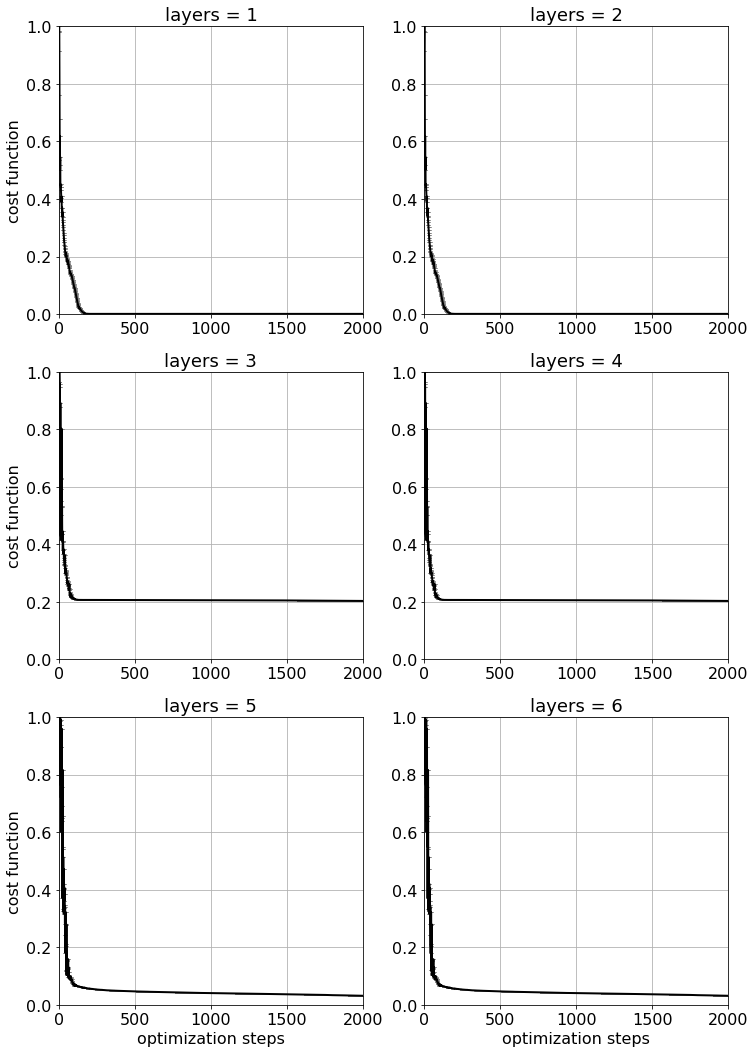

In [127]:
# Plot Cost
fig = plt.figure(figsize=(12, 18),facecolor=(1, 1, 1))
nrows = 3
ncols = 2
xmax = 2000
gs = fig.add_gridspec(nrows,ncols)
count = 0
h,x = create_grid(n,0,n)
for i in range(nrows):
    for j in range(ncols):
        ax = fig.add_subplot(gs[i, j])
        ilayer = layer_start + count
        ax.errorbar(x, cost_avg[i], cost_std[i],color='black',linestyle='-',linewidth=2.0,ecolor='gray', elinewidth=1, capsize=2, label="layers = " + str(ilayer))
        if count==0 or count==2 or count==4:
            ax.set_ylabel("cost function", fontsize=16)
        #ax.set_xlabel("x", fontsize=12)
        ax.grid()
        ax.set_xlim(0,xmax)
        ax.set_ylim(0,1)
        ax.set_title('layers = %d'%(ilayer),color="black",fontsize=18)
        ax.tick_params(axis='both', which='major', labelsize=16)
        count = count + 1
        if i == nrows - 1:
            ax.set_xlabel("optimization steps", fontsize=16)
        
        if count == layer_range:
            break
fname = case + "_LayerRange_" + str(layer_range) + "_layerStart_" + str(layer_start) + "_runRange_" + str(run_range) + "_" + str(nqbits) + "qbit_cost.png"
plt.savefig(fname,dpi=300,format='png',bbox_inches='tight')
plt.show()

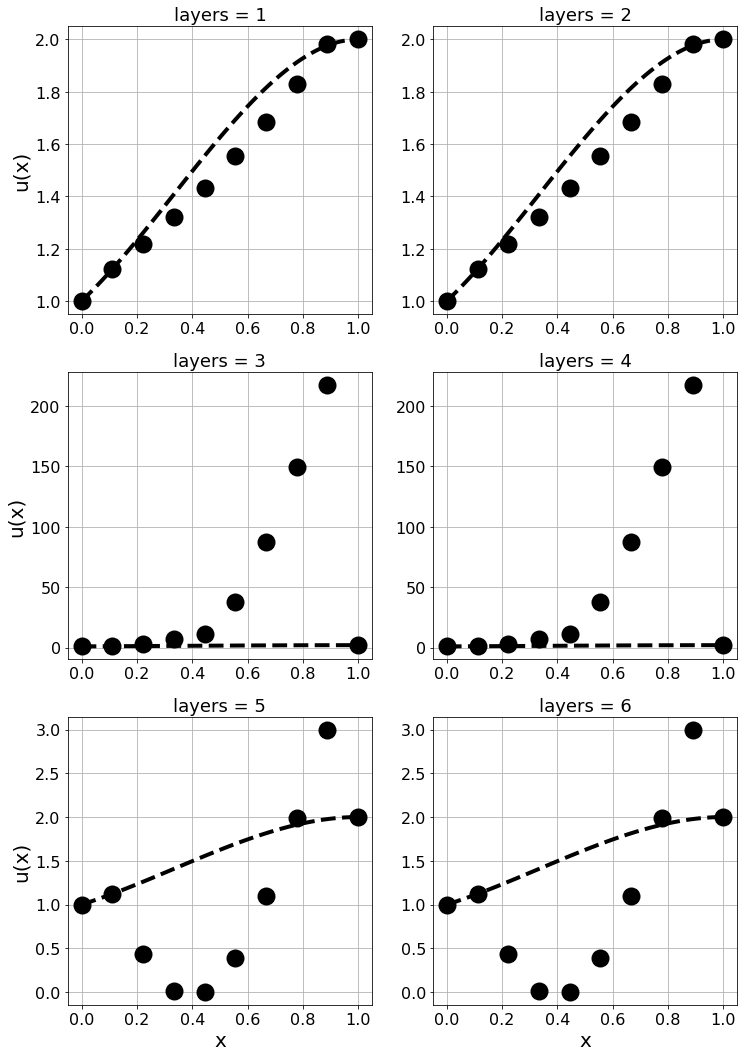

In [125]:
# Plot Solution
xl = 0
xr = 1
nx = 2**nqbits + 2
hp,xp = create_grid(101,xl,xr)
h,x = create_grid(nx,xl,xr)
fig = plt.figure(figsize=(12, 18),facecolor=(1, 1, 1))
nrows = 3
ncols = 2
xmin = -0.05
xmax =  xr - xmin
ymin = np.min(u_analytic(xp)) - 0.1
if np.min(u_avg) < ymin:
    ymin = np.min(u_avg) - 0.1
if np.max(u_avg) > ymax:
    ymax = np.max(u_avg) + 0.1
ymax = np.max(u_analytic(xp)) + 0.1 * np.max(u_analytic(xp))
gs = fig.add_gridspec(nrows,ncols)
count = 0
for i in range(nrows):
    for j in range(ncols):
        ax = fig.add_subplot(gs[i, j])
        ilayer = layer_start + count
        ax.errorbar(x, u_avg[i], u_std[i],color="black",linestyle='none',marker='o',markersize=15,markerfacecolor='black',markeredgewidth=3, linewidth=2.0,label='Discrete Solution',ecolor='gray', elinewidth=2, capsize=5)
        ax.plot(xp,u_analytic(xp),color="black",linestyle='--',linewidth=4.0,label='Analytic Solution')
        if count==0 or count==2 or count==4:
            ax.set_ylabel("u(x)", fontsize=20)
        #ax.set_xlabel("x", fontsize=12)
        ax.grid()
        ax.set_xlim(xmin,xmax)
        #ax.set_ylim(ymin,ymax)
        ax.set_title('layers = %d'%(ilayer),color="black",fontsize=18)
        ax.tick_params(axis='both', which='major', labelsize=16)
        count = count + 1
        if i == nrows - 1:
            ax.set_xlabel("x", fontsize=20)
        
        if count == layer_range:
            break
fname = case + "_LayerRange_" + str(layer_range) + "_layerStart_" + str(layer_start) + "_runRange_" + str(run_range) + "_" + str(nqbits) + "qbit_u.png"
plt.savefig(fname,dpi=300,format='png',bbox_inches='tight')
plt.show()